In [1]:
import torch
import torch.nn as nn
import FrEIA.framework as Ff
import FrEIA.modules as Fm
import pandas as pd
import uproot
import torch.distributions as dist
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
import matplotlib

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

matplotlib.rcParams['figure.figsize'] = [15, 10]
plt.rcParams.update({'axes.labelsize': 14})

/ceph/lsowa/envs/snow/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = '/ceph/lsowa/recoil/dt.root'
dfdata = None
for file in uproot.iterate(path+":ntuple", library="pd"):
    if dfdata is None:
        dfdata = pd.DataFrame.from_dict(file)
    else:
        df = pd.DataFrame.from_dict(file)
        dfdata = pd.concat([dfdata, df])

/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

In [3]:
path = '/ceph/lsowa/recoil/mc.root'
dfmc = None
for file in uproot.iterate(path+":ntuple", library="pd"):
    if dfmc is None:
        dfmc = pd.DataFrame.from_dict(file)
    else:
        df = pd.DataFrame.from_dict(file)
        dfmc = pd.concat([dfmc, df])

/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/ceph/lsowa/envs/snow/lib/python3.9/site-packages/uproot/interpretation/library.py:805: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

In [4]:
print('MC shape ', dfmc.shape)
print('Data shape ', dfdata.shape)

MC shape  (2189044, 213)
Data shape  (1796149, 172)


In [38]:
cond = [
'pt_vis_c',
'phi_vis_c',
'dxyErr_1',
'dxyErr_2',
'dxy_1',
'dxy_2',
'dxybs_1',
'dxybs_2',
'dzErr_1',
'dzErr_2',
'dz_1',
'dz_2',
'eta_1',
'eta_2',
'highPtId_1',
'highPtId_2',
'highPurity_1',
'highPurity_2',
'mass_1',
'mass_2',
'metSumEt',
'metcov00',
'metcov01',
'metcov10',
'metcov11',
'metphi',
'mjj',
'phi_1',
'phi_2',
'ptErr_1',
'ptErr_2',
'pt_1',
'pt_2']
cond = ['metphi','pt_vis_c',
'phi_vis_c','pt_1',
'pt_2','dxy_1',
'dxy_2','dz_1',
'dz_2','eta_1',
'eta_2','mass_1',
'mass_2','metSumEt']
names = ['uP1_uncorrected', 'uP2_uncorrected']

In [107]:
n = 200000
data = dfdata[names].to_numpy().astype(float)[:200000,:]
mc = dfmc[names].to_numpy().astype(float)[:100000,:]
cdata = dfdata[cond].to_numpy().astype(float)[:200000,:]
cmc = dfmc[cond].to_numpy().astype(float)[:100000,:]

In [108]:
input_scaler = StandardScaler()
data = input_scaler.fit_transform(data)
mc = input_scaler.transform(mc)

cond_scaler = StandardScaler()
cdata = cond_scaler.fit_transform(cdata)
cmc = cond_scaler.transform(cmc)

In [109]:
data, mc, cdata, cmc = torch.tensor(data), torch.tensor(mc), torch.tensor(cdata), torch.tensor(cmc)

In [110]:
lr = 0.001
device = torch.device('cuda:3')

In [111]:
def mlp_constructor(input_dim=2, out_dim=2, hidden_nodes=300):
    model = nn.Sequential(
        nn.Linear(input_dim, hidden_nodes),
        nn.ReLU(),
        #nn.Linear(hidden_nodes, hidden_nodes),
        #nn.ReLU(),
        #nn.Linear(hidden_nodes, hidden_nodes),
        #nn.ReLU(),
        #nn.Linear(hidden_nodes, hidden_nodes),
        #nn.ReLU(),
        nn.Linear(hidden_nodes, hidden_nodes),
        nn.ReLU(),
        nn.Linear(hidden_nodes, out_dim)
        )
    return model

In [112]:
model = Ff.SequenceINN(2)
for k in range(15):
    model.append(Fm.RNVPCouplingBlock, subnet_constructor=mlp_constructor, clamp=2, cond=0, cond_shape=(cmc.shape[1],))
    #model.append(Fm.PermuteRandom)

In [113]:
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=2, verbose=True)

In [114]:
dataset = TensorDataset(data, cdata)
loader = DataLoader(dataset, shuffle=True, batch_size=5000)

In [115]:
pz = dist.MultivariateNormal(torch.zeros(2), torch.eye(2))
model.to(device)

losses = []
nbatches = len(loader)
stopper=0
best_loss=np.inf
epoch = 0
best_model_dict = None
while stopper<=10:
    epo_loss = 0
    for d, c in loader:
        d = d.to(device)
        c = c.to(device)
        
        z, log_jac = model(d.float(), c=[c.float()])
        
        zz = torch.sum(z**2, dim=-1)
        neg_log_likeli = 0.5 * zz - log_jac
        loss = torch.mean(neg_log_likeli)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epo_loss += loss.cpu().detach().numpy()
    epo_loss /= nbatches
    epo_loss = round(epo_loss,5)
    scheduler.step(epo_loss)
    losses.append(epo_loss)
    
    if epo_loss >= best_loss: 
        stopper+=1
    else:
        best_loss = epo_loss
        stopper = 0
        best_model_dict = model.state_dict()
    epoch += 1
    
    print('Epoch: {:.0f}; Loss: {:.3f}; stopper: {:.0f}; best loss: {:.3f}\n'.format(epoch, epo_loss, stopper, best_loss), end="\r")



Epoch: 1; Loss: 2521.770; stopper: 0; best loss: 2521.770
Epoch: 2; Loss: 43.240; stopper: 0; best loss: 43.240
Epoch: 3; Loss: 2.968; stopper: 0; best loss: 2.968
Epoch: 4; Loss: 0.012; stopper: 0; best loss: 0.012
Epoch: 5; Loss: -0.876; stopper: 0; best loss: -0.876
Epoch: 6; Loss: -1.208; stopper: 0; best loss: -1.208
Epoch: 7; Loss: -1.282; stopper: 0; best loss: -1.282
Epoch: 8; Loss: -1.435; stopper: 0; best loss: -1.435
Epoch: 9; Loss: -1.506; stopper: 0; best loss: -1.506
Epoch: 10; Loss: -1.729; stopper: 0; best loss: -1.729
Epoch: 11; Loss: -1.899; stopper: 0; best loss: -1.899
Epoch: 12; Loss: -1.830; stopper: 1; best loss: -1.899
Epoch: 13; Loss: -1.975; stopper: 0; best loss: -1.975
Epoch: 14; Loss: -2.105; stopper: 0; best loss: -2.105
Epoch: 15; Loss: -2.186; stopper: 0; best loss: -2.186
Epoch: 16; Loss: -2.275; stopper: 0; best loss: -2.275
Epoch: 17; Loss: -2.292; stopper: 0; best loss: -2.292
Epoch: 18; Loss: -2.248; stopper: 1; best loss: -2.292
Epoch: 19; Loss: -1

KeyboardInterrupt: 

Text(0, 0.5, 'Loss')

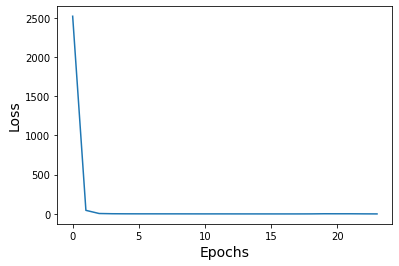

In [116]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [117]:
model.load_state_dict(best_model_dict)

<All keys matched successfully>

In [118]:
model.cpu()
z, _ = model(data.float(), c=[cdata.float()])
gaussian = pz.sample((100000, ))

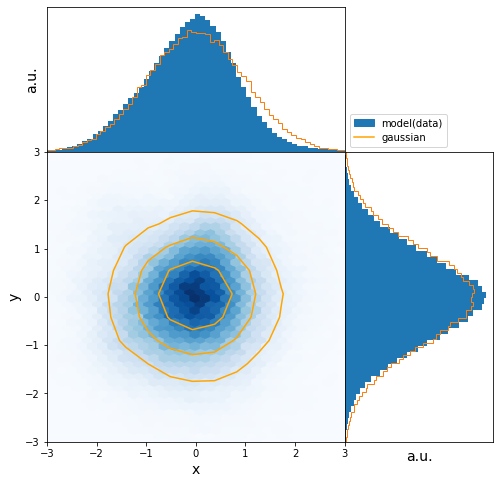

In [119]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'width_ratios': [2, 1],
                                                          'height_ratios': [1, 2]})
plt.subplots_adjust(hspace=0, wspace=0)

xlim = [-3, 3]
ylim = [-3, 3]
# heatmap
ax[1,0].hexbin(z[:,0].cpu().detach().numpy(), z[:,1].cpu().detach().numpy(), label='model(data)', gridsize=(50,50), cmap='Blues')

counts, ybins, xbins, image = ax[1,0].hist2d(gaussian[:,0].cpu().detach().numpy(), gaussian[:,1].cpu().detach().numpy(), bins=20, alpha=0.0)
contours = ax[1,0].contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                colors='orange', levels=3)
ax[1,0].plot([], [], '-', label='gaussian', color='orange')
ax[1,0].set_ylim([-3, 3])
ax[1,0].set_xlim(xlim)
ax[1,0].set_xlabel('x')
ax[1,0].set_ylabel('y')
ax[1,0].legend(loc='lower left', bbox_to_anchor=(1,1))


# x axis
_ = ax[0,0].hist(z[:,0].cpu().detach().numpy(), bins=100, density=True, label='model(data)')
_ = ax[0,0].hist(gaussian[:,0].cpu().detach().numpy(), bins=100, density=True, histtype=u'step', label='gaussian')
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,0].set_ylabel('a.u.')
ax[0,0].set_xlim(xlim)

# y axis
_ = ax[1,1].hist(z[:,1].cpu().detach().numpy(), bins=100, density=True, label='model(data)',orientation='horizontal')
_ = ax[1,1].hist(gaussian[:,1].cpu().detach().numpy(), bins=100, density=True, histtype=u'step', label='gaussian', orientation='horizontal')
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[1,1].set_xlabel('a.u.')
ax[1,1].set_ylim(xlim)

# third wheel
_ = ax[0,1].axis('off')

In [89]:
z = gaussian #pz.sample((100000, ))
#z = z.to(device)
u, log_jac = model(z, rev=True, c=[cmc.float()])
u = u.cpu().detach().numpy()
u = input_scaler.inverse_transform(u)

In [90]:

data = input_scaler.inverse_transform(data)

### Compare MC -> Data

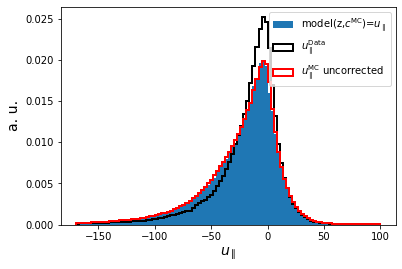

In [91]:
plt.clf()
interval = [-170, 100]
_ = plt.hist(u[:,0], density=True, bins=100, range=interval, label=r'model(z,$c^\mathrm{MC}$)=$u_\parallel$')
_ = plt.hist(data[:,0], histtype=u'step', density=True, bins=100, range=interval, linewidth=2, color='black', label=r'$u^\mathrm{Data}_\parallel$')
_ = plt.hist(dfmc['uP1_uncorrected'].values, histtype=u'step', density=True, bins=100, range=interval, linewidth=2, color='red', label=r'$u^\mathrm{MC}_\parallel$ uncorrected')
plt.xlabel(r'$u_\parallel$')
plt.ylabel('a. u.')
plt.legend()

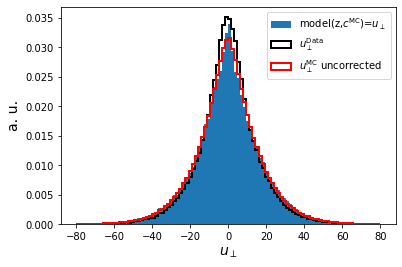

In [92]:
plt.clf()
interval = [-80, 80]
_ = plt.hist(u[:,1], density=True, bins=100, range=interval, label=r'model(z,$c^\mathrm{MC}$)=$u_\perp $')
_ = plt.hist(data[:,1], histtype=u'step', density=True, bins=100, range=interval, linewidth=2, color='black', label=r'$u^\mathrm{Data}_\perp $')
_ = plt.hist(dfmc['uP2_uncorrected'].values, histtype=u'step', density=True, bins=100, range=interval, linewidth=2, color='red', label=r'$u^\mathrm{MC}_\perp $ uncorrected')
plt.xlabel(r'$u_\perp$')
plt.ylabel('a. u.')
plt.legend()

In [93]:
ptz = dfmc['pt_vis_c'][:100000]
up = u[:,0]

In [94]:
keep = np.logical_and(200 > ptz, ptz > 25)
ptz = ptz[keep]
up = up[keep]
r = -up/ptz

In [95]:
xmin = 25
xmax = 200
bins = np.linspace(20,200,10)
bin_mids = (bins[1:]-bins[:-1])/2 + bins[:-1]
hist_raw, edges = np.histogram(ptz, bins = bins, range=[xmin, xmax])
hist_weighted, edges = np.histogram(ptz, bins = bins, weights=r, range=[xmin, xmax])

(20.0, 200.0)

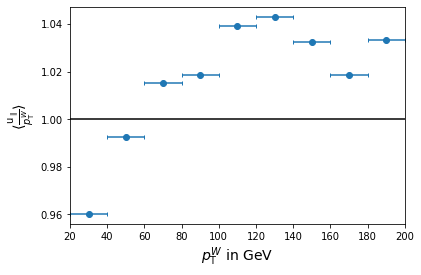

In [96]:
#plt.plot(bin_mids, hist_weighted/hist_raw, '.')
plt.hlines([1], bins.min(), bins.max(), color='black')
plt.errorbar(x=bin_mids, y=hist_weighted/hist_raw,
            xerr=(bins[1:]-bins[:-1])/2, fmt='o', capsize=2)
plt.xlabel(r'$p_\mathrm{T}^W$ in GeV')
plt.ylabel(r'$\langle \frac{\mathrm{u}_\parallel}{p_\mathrm{T}^W}\rangle$')
plt.xlim([bins.min(), bins.max()])
#plt.grid()

Text(0, 0.5, 'a.u.')

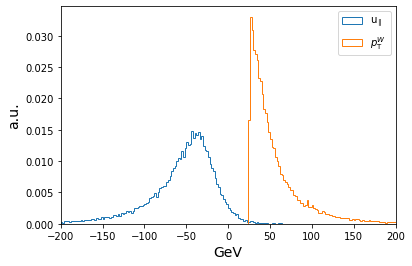

In [97]:
n, bins, edges = plt.hist(up, histtype=r'step', bins=200, range=[-200, 200], density=True, label=r'$\mathrm{u}_\parallel$')
n1, bins1, edges1 = plt.hist(ptz, histtype=r'step', bins=200, range=[-200, 200], density=True, label=r'$p_\mathrm{T}^W}\rangle$')
plt.xlim([-200, 200])
plt.legend()
plt.xlabel('GeV')
plt.ylabel('a.u.')
